In [3]:
from fastai.vision.all import *

In [4]:
pwd

'C:\\Users\\hammad jamil'

In [5]:
import os
path=os.chdir('C:\\Users\\hammad jamil\\Desktop')

In [6]:
path=Path.cwd()
path

Path('C:/Users/hammad jamil/Desktop')

In [7]:
path=path/'fruit_data'
path.ls()

(#4) [Path('C:/Users/hammad jamil/Desktop/fruit_data/test'),Path('C:/Users/hammad jamil/Desktop/fruit_data/train'),Path('C:/Users/hammad jamil/Desktop/fruit_data/valid'),Path('C:/Users/hammad jamil/Desktop/fruit_data/_annotations.json')]

In [8]:
imgs, lbl_bbox = get_annotations(path/'_annotations.json')

In [9]:
lbl_bbox[0]

([[222, 343, 318, 403],
  [414, 361, 544, 424],
  [305, 360, 408, 419],
  [188, 372, 238, 416],
  [359, 525, 452, 589],
  [438, 519, 528, 604],
  [272, 524, 365, 592],
  [178, 537, 277, 605],
  [348, 121, 400, 155],
  [426, 127, 499, 163],
  [472, 137, 557, 162],
  [460, 244, 498, 287],
  [181, 251, 312, 315],
  [438, 263, 561, 324],
  [332, 277, 459, 319]],
 ['banana',
  'chicken',
  'tomato',
  'corn',
  'potato',
  'onion',
  'strawberries',
  'beef',
  'cheese',
  'goat_cheese',
  'lime',
  'heavy_cream',
  'butter',
  'green_beans',
  'carrot'])

In [10]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [11]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'DSC_5856_JPG_jpg.rf.1d810f755765f821ecc727f8f2213b8d.jpg': ([[222,
    343,
    318,
    403],
   [414, 361, 544, 424],
   [305, 360, 408, 419],
   [188, 372, 238, 416],
   [359, 525, 452, 589],
   [438, 519, 528, 604],
   [272, 524, 365, 592],
   [178, 537, 277, 605],
   [348, 121, 400, 155],
   [426, 127, 499, 163],
   [472, 137, 557, 162],
   [460, 244, 498, 287],
   [181, 251, 312, 315],
   [438, 263, 561, 324],
   [332, 277, 459, 319]],
  ['banana',
   'chicken',
   'tomato',
   'corn',
   'potato',
   'onion',
   'strawberries',
   'beef',
   'cheese',
   'goat_cheese',
   'lime',
   'heavy_cream',
   'butter',
   'green_beans',
   'carrot'])}

In [12]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]


In [13]:
item_tfms = [Resize(128, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [14]:
def get_train_imgs(noop):  return imgs

In [15]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [16]:
dls = pascal.dataloaders(path/'train')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [17]:
dls.c = 30

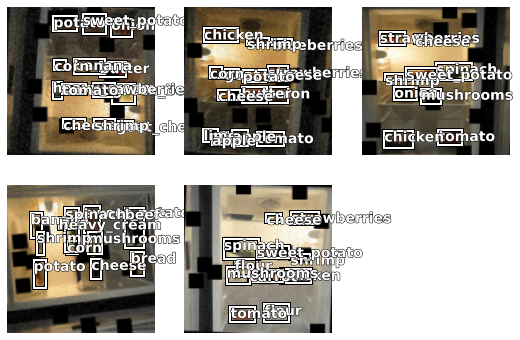

In [18]:
dls.show_batch(max_n=5)

In [19]:
from wwf.vision.object_detection import *

In [20]:
encoder = create_body(resnet34, pretrained=True)

In [21]:
get_c(dls)


30

In [22]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)


In [23]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [24]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [25]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)


In [26]:
TensorImage.register_func(torch.nn.functional.smooth_l1_loss, TensorImage, TensorBBox)
TensorMultiCategory.register_func(TensorMultiCategory.mul, TensorMultiCategory, TensorImage)
TensorImage.register_func(torch.nn.functional.binary_cross_entropy_with_logits, TensorImage, TensorMultiCategory)

In [27]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [28]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)


In [29]:
learn.freeze()

In [30]:
learn.fit_one_cycle(3, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,2.751943,2.348128,22:12
1,2.455077,2.250733,23:14
2,2.338723,2.235114,21:15


In [32]:
learn.save('fruit')

Path('models/fruit.pth')